<a href="https://colab.research.google.com/github/myazdani/high-contrast-baby-images/blob/main/output_layer_entropies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import glob

## download images

Two data sets:
1. **ImageNet sample:** found sample of images from ImageNet on github
2. **Random images**: download random images from unsplash image hosting site with ImageNet class names

In [2]:
#download sample of ImageNet images
!git clone https://github.com/EliSchwartz/imagenet-sample-images.git


image_files = glob.glob('./imagenet-sample-images/*.JPEG')

Cloning into 'imagenet-sample-images'...
remote: Enumerating objects: 1012, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1012 (delta 3), reused 5 (delta 2), pack-reused 1002
Receiving objects: 100% (1012/1012), 103.84 MiB | 28.07 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (1002/1002), done.


In [3]:
import re
image_classes = []
for image_file in image_files:
    m = re.search('n[0-9]+_', image_file)
    img_id = m.group(0)
    image_class = image_file.split(img_id)[1].split(".JPEG")[0]
    image_classes.append(image_class)

In [4]:
import requests
import random
import string
from PIL import Image


def download_images(image_class, image_dir, num_images=1):
    for i in range(num_images):
        # Generate image URL based on image class
        image_url = f"https://source.unsplash.com/random/800x600/?{image_class}"


        # Download the image
        response = requests.get(image_url)
        if response.status_code == 200:
            image_path = f"{image_dir}{image_class}_{i}.jpg"
            with open(image_path, 'wb') as file:
                file.write(response.content)
        else:
            print(f"Failed to download image {image_class} {i+1} from: {image_url}")




In [ ]:
!mkdir unsplash-images/
for image_class in image_classes:
    download_images(image_class, image_dir = "./unsplash-images/", num_images=1)

In [ ]:
unsplash_image_files = glob.glob('./unsplash-images/*.jpg')

In [ ]:
!git clone https://github.com/myazdani/high-contrast-baby-images.git

In [ ]:
high_contrast_images = glob.glob('./high-contrast-baby-images/images/*.png')

## helpers

In [ ]:
class ActivationExtractor:
    def __init__(self, model, transform=None):
        self.model = model
        if transform is not None:
            self.transform = transform
        else:
            self.transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        self.model.eval()
        self.activations = {}


    def _register_hook(self, layer_name):
        def hook(model, input, output):
            self.activations[layer_name] = output.detach()
        return hook

    def _transform_image(self, image_path):
        image = Image.open(image_path)
        image = self.transform(image)
        image = image.unsqueeze(0)  # add a dimension for the batch
        return image

    def get_activations_by_name(self, image_path, layer_name):
        # Attach the hook
        layer = dict([*self.model.named_modules()])[layer_name]
        handle = layer.register_forward_hook(self._register_hook(layer_name))

        # Prepare and run the input image through the model
        image = self._transform_image(image_path)
        self.model(image)

        # Remove the hook
        handle.remove()

        return self.activations[layer_name]

    def get_activations_by_index(self, image_path, layer_index):
        layer_name = list(dict([*self.model.named_modules()]).keys())[layer_index]
        return self.get_activations_by_name(image_path, layer_name)

    def get_flattened_activations(self, image_path, layer_name):
        return self.get_activations(image_path, layer_name).flatten()

import copy

def combine_models(model_cls, alpha=0.5):
    model_pretrained = model_cls(pretrained=True)
    model_random = model_cls(pretrained=False)
    model_combined = copy.deepcopy(model_pretrained)

    for (name_combined, param_combined), (_, param_random) in zip(model_combined.named_parameters(), model_random.named_parameters()):
        param_combined.data = alpha * param_combined.data + (1 - alpha) * param_random.data

    return model_combined


In [ ]:
def fetch_entropies(extractor, image_files):
    entropies = []
    bad_images = []
    for image_file in image_files:
        try:
            activations = extractor.get_activations_by_index(image_file, -1)  # for last layer
            p = torch.nn.functional.softmax(activations.flatten())
            H = -torch.sum(p*torch.nn.functional.log_softmax(activations.flatten()))
            entropies.append(H)
        except:
            bad_images.append(image_file)
    return entropies, bad_images

## VGG entropies

In [ ]:
%%time
extractor = ActivationExtractor(models.vgg16(pretrained=True))
vgg_trained_entropies = fetch_entropies(extractor, image_files)
vgg_trained_unsplash_entropies = fetch_entropies(extractor, unsplash_image_files)
vgg_trained_high_contrast_entropies = fetch_entropies(extractor, high_contrast_images)

In [ ]:
%%time
extractor = ActivationExtractor(models.vgg16(pretrained=False))
vgg_untrained_entropies = fetch_entropies(extractor, image_files)
vgg_untrained_unsplash_entropies = fetch_entropies(extractor, unsplash_image_files)
vgg_untrained_high_contrast_entropies = fetch_entropies(extractor, high_contrast_images)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-10-c751040264c3>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = torch.nn.functional.softmax(activations.flatten())
<ipython-input-10-c751040264c3>:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  H = -torch.sum(p*torch.nn.functional.log_softmax(activations.flatten()))


## visualize results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

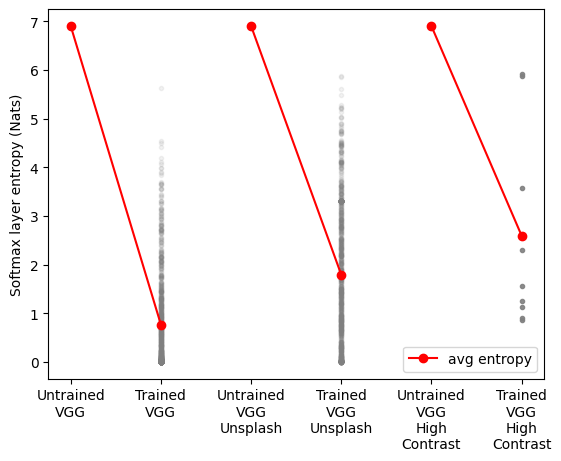

In [15]:


results = [
    vgg_untrained_entropies[0],
    vgg_trained_entropies[0],
    vgg_untrained_unsplash_entropies[0],
    vgg_trained_unsplash_entropies[0],
    vgg_untrained_high_contrast_entropies[0],
    vgg_trained_high_contrast_entropies[0],
]
plt.plot([0,1], results[:2], '.', color = 'grey', alpha = 0.1);
plt.plot([2,3], results[2:4], '.', color = 'grey', alpha = 0.1);
plt.plot([4,5], results[4:], '.', color = 'grey', alpha = 0.9);
avg_results = [
    torch.mean(torch.tensor(vgg_untrained_entropies[0])),
    torch.mean(torch.tensor(vgg_trained_entropies[0])),
    torch.mean(torch.tensor(vgg_untrained_unsplash_entropies[0])),
    torch.mean(torch.tensor(vgg_trained_unsplash_entropies[0])),
    torch.mean(torch.tensor(vgg_untrained_high_contrast_entropies[0])),
    torch.mean(torch.tensor(vgg_trained_high_contrast_entropies[0])),
]
plt.plot([0,1], avg_results[:2], '-o', color = 'red');
plt.plot([2,3], avg_results[2:4], '-o', color = 'red');
plt.plot([4,5], avg_results[4:], '-o', color = 'red', label = "avg entropy");
plt.ylabel("Softmax layer entropy (Nats)")
xlabels = [
    "Untrained\nVGG",
    "Trained\nVGG",
    "Untrained\nVGG\nUnsplash",
    "Trained\nVGG\nUnsplash",
    "Untrained\nVGG\nHigh\nContrast",
    "Trained\nVGG\nHigh\nContrast",
]
plt.xticks([0,1,2,3,4,5], xlabels)
plt.legend();